<a href="https://colab.research.google.com/github/ko74dev/ko74dev.github.io/blob/main/RBK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from catboost import CatBoostClassifier

In [ ]:
df_train = pd.read_csv("train_dataset_train.csv", index_col= 0)
df_test = pd.read_csv("test_dataset_test.csv", index_col= 0)

In [ ]:
X = pd.DataFrame()
X['title'] = pd.concat([df_train['title'], df_test['title']])
X['ctr'] = pd.concat([df_train['ctr'], df_test['ctr']])

In [ ]:
X = pd.concat([X,
                pd.get_dummies( pd.concat(
[df_train['category'], df_test['category']]).astype('category').cat.codes.astype('uint8'),
                prefix='Cat')], axis=1)

In [ ]:
Date = pd.to_datetime(pd.concat([df_train['publish_date'], df_test['publish_date']]))
X = pd.concat([X,
    pd.get_dummies(Date.dt.month, prefix='M'), 
    pd.get_dummies(Date.dt.day, prefix='D'), 
    pd.get_dummies(Date.dt.weekday, prefix='W')], axis=1)

In [ ]:
Tags = pd.concat([df_train['tags'], df_test['tags']]
         ).map(lambda x: [y.strip("'")[:2] for y in x.strip("[]").split(', ')])

In [ ]:
d = set()
for i in df_train.tags.map(lambda x: 
                           [y.strip("'")[:2] for y in x.strip("[]").split(', ')]).values:
    for j in i: d |={j.strip("'")}
for k in pd.Series([*d]):
    X[f'T_{k}'] = 0

In [ ]:
for i in X.index:
    for j in Tags[i]:
        X.loc[i, f'T_{j}'] = 1

X.iloc[:,-16:] = X.iloc[:,-16:].astype('uint8')

Заменим автора на число

In [ ]:
Authors =  pd.concat([df_train['authors'], df_test['authors']]
                        ).astype('category').cat.codes.astype('uint')

Authors.quantile(.25)-1.5*(
    Authors.quantile(.5)-Authors.quantile(.25))

redkie = Authors.value_counts()<44

In [ ]:
Authors.loc[
    Authors.isin(redkie[redkie.isin(redkie[redkie.isin([True])])].index)] = 740

In [ ]:
X["authors"] = Authors.copy()
X["authors"] = X["authors"].astype('category').cat.codes.astype('uint8')
X["authors"].unique()

array([22, 23,  4, 20, 13,  6, 15, 17,  8,  2,  3, 21,  0,  9, 16, 18, 10,
        1, 11, 19, 14,  5,  7, 12], dtype=uint8)

In [ ]:
X = pd.concat([X,
    pd.get_dummies(X["authors"], prefix='A')], axis=1)

X.drop(columns=['authors'], inplace=True)

## Выделим выборки

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                X.loc[df_train.index], 
                                        df_train[["views","depth","full_reads_percent"]], 
                                                test_size=0.15, random_state=42)

## Подбор модели

## Оценка точности

In [ ]:
from sklearn.metrics import r2_score

pred_views = cbr_views2.predict(X_test)

pred_depth = cbr_depth2.predict(X_test)

pred_full_reads_percent = cbr_full_reads_percent2.predict(X_test)

In [ ]:
score_views = r2_score(y_test["views"], pred_views)
score_depth = r2_score(y_test["depth"], pred_depth)
score_frp = r2_score(y_test["full_reads_percent"], pred_full_reads_percent)

score = 0.4 * score_views + 0.3 * score_depth + 0.3 * score_frp
score, score_views, score_depth, score_frp

(0.638812687937887, 0.758207164237567, 0.757165968824053, 0.3612667719854813)

In [ ]:
# 0.630 lr 0.2 l2 = 4 iter = 250

In [ ]:
sub = df_train = pd.read_csv("sample_solution.csv", index_col= 0)
sub['views'],sub['depth'],sub['full_reads_percent'] = cbr_views2.predict(
X.loc[df_test.index]), cbr_depth2.predict(X.loc[df_test.index]),\
cbr_full_reads_percent2.predict(X.loc[df_test.index])

In [ ]:
y_frp = df_train["full_reads_percent"]
y_frp = y_frp.clip(0, y_frp.quantile(.99))
X_train, X_test, y_train, y_test = train_test_split(
                                                X.loc[df_train.index], y_frp, 
                                                test_size=0.15, random_state=42)

from catboost import CatBoostRegressor

params = {'eval_metric': 'R2', 
          'task_type': 'CPU', 
          'iterations': 3000, # 150 450
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli',
#           'allow_const_label': True, 
         }

cbr_frp0 = CatBoostRegressor(**params,  random_seed=42, 
                             learning_rate=.05, depth=6, l2_leaf_reg= 4, 
                                early_stopping_rounds=80, verbose = 100)
cbr_frp0.fit(X_train, y_train, eval_set=(X_test, y_test))

cbr_frp1 = CatBoostRegressor(**params,  random_seed=42, 
                             learning_rate=.04, depth=6, #l2_leaf_reg= 5, 
                                early_stopping_rounds=70, verbose = 100)
cbr_frp1.fit(X_train, y_train, eval_set=(X_test, y_test), init_model=cbr_frp0)

cbr_frp2 = CatBoostRegressor(**params,  random_seed=42, 
                             learning_rate=.03, depth=7, #l2_leaf_reg= 5, 
                                early_stopping_rounds=60, verbose = 100)
cbr_frp2.fit(X_train, y_train, eval_set=(X_test, y_test), init_model=cbr_frp1)

0:	learn: 0.0241095	test: 0.0237912	best: 0.0237912 (0)	total: 2.39ms	remaining: 7.18s
100:	learn: 0.3543092	test: 0.3656264	best: 0.3656264 (100)	total: 242ms	remaining: 6.93s
200:	learn: 0.3983244	test: 0.3816243	best: 0.3816243 (200)	total: 452ms	remaining: 6.3s
300:	learn: 0.4357735	test: 0.3941930	best: 0.3943919 (298)	total: 694ms	remaining: 6.22s
400:	learn: 0.4637852	test: 0.3971658	best: 0.3972306 (399)	total: 982ms	remaining: 6.37s
500:	learn: 0.4857546	test: 0.3988920	best: 0.3993780 (487)	total: 1.28s	remaining: 6.37s
600:	learn: 0.5058331	test: 0.4001600	best: 0.4001826 (598)	total: 1.56s	remaining: 6.22s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.4005821221
bestIteration = 604

Shrink model to first 605 iterations.
0:	learn: 0.5066458	test: 0.4005238	best: 0.4005238 (0)	total: 2.54ms	remaining: 7.63s
100:	learn: 0.5153999	test: 0.4006579	best: 0.4012812 (38)	total: 216ms	remaining: 6.21s
Stopped by overfitting detector  (70 iterations wait)

bestT

In [ ]:
# 0.4013133188

In [ ]:
r2_score(df_train["full_reads_percent"][y_test.index], cbr_frp2.predict(X_test))

0.4005669695995657

In [ ]:
y_frp = df_train["full_reads_percent"]
y_frp = y_frp.map(log)

X_train, X_test, y_train, y_test = train_test_split(X.loc[df_train.index], y_frp, 
                                                    test_size=0.15, random_state=42)

params = {'eval_metric': 'R2', 
          'task_type': 'CPU', 
          'iterations': 3000, # 150 450
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli',
         }

cbr_frp0 = CatBoostRegressor(**params,  random_seed=42, 
                             learning_rate=.05, depth=6, l2_leaf_reg= 4, 
                                early_stopping_rounds=80, verbose = 100)
cbr_frp0.fit(X_train, y_train, eval_set=(X_test, y_test))

cbr_frp1 = CatBoostRegressor(**params,  random_seed=42, 
                             learning_rate=.04, depth=7, #l2_leaf_reg= 5, 
                                early_stopping_rounds=70, verbose = 100)
cbr_frp1.fit(X_train, y_train, eval_set=(X_test, y_test), init_model=cbr_frp0)

cbr_frp2 = CatBoostRegressor(**params,  random_seed=42, 
                             learning_rate=.03, depth=8, #l2_leaf_reg= 5, 
                                early_stopping_rounds=60, verbose = 100)
cbr_frp2.fit(X_train, y_train, eval_set=(X_test, y_test), init_model=cbr_frp1)

# 0.4137262017
r2_score(df_train["full_reads_percent"][y_test.index], exp(cbr_frp2.predict(X_test)))

0:	learn: 0.0216520	test: 0.0214434	best: 0.0214434 (0)	total: 3.17ms	remaining: 9.51s
100:	learn: 0.3614943	test: 0.3718884	best: 0.3718884 (100)	total: 224ms	remaining: 6.42s
200:	learn: 0.4114915	test: 0.3926188	best: 0.3926188 (200)	total: 431ms	remaining: 6.01s
300:	learn: 0.4549602	test: 0.4071493	best: 0.4071877 (282)	total: 654ms	remaining: 5.86s
400:	learn: 0.4838578	test: 0.4093202	best: 0.4096719 (383)	total: 857ms	remaining: 5.55s
500:	learn: 0.5105992	test: 0.4103422	best: 0.4111164 (487)	total: 1.14s	remaining: 5.69s
600:	learn: 0.5327158	test: 0.4126078	best: 0.4126078 (600)	total: 1.44s	remaining: 5.73s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.4134541651
bestIteration = 613

Shrink model to first 614 iterations.
0:	learn: 0.5360207	test: 0.4133387	best: 0.4133387 (0)	total: 3.08ms	remaining: 9.25s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.4136354567
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.

0.39216370025609104

<AxesSubplot:>

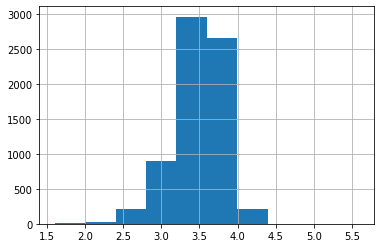

In [ ]:
from numpy import log, exp
df_train["full_reads_percent"].map(log).hist()

<AxesSubplot:>

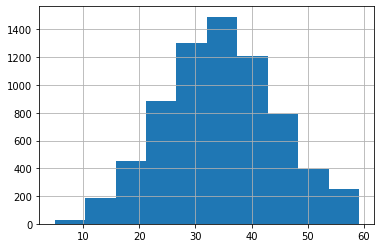

In [ ]:
df_train["full_reads_percent"].clip(0,
       df_train["full_reads_percent"].quantile(.99)).hist()

In [ ]:
y_frp = df_train["full_reads_percent"].map(round)
# y_frp = y_frp.clip(0, y_frp.quantile(.99)).map(round)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X.loc[df_train.index], y_frp, test_size=0.15, random_state=42)

params = {'task_type': 'GPU'}
model2= CatBoostClassifier(**params,  
                          random_seed=42, iterations=5000,
                          learning_rate=.005, 
                          depth=7, l2_leaf_reg= 6, 
                          early_stopping_rounds=10,# verbose = 100, 
                                text_features=['title'])
model2.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 4.2012543	test: 4.2015513	best: 4.2015513 (0)	total: 175ms	remaining: 14m 35s
1:	learn: 4.1966551	test: 4.1969345	best: 4.1969345 (1)	total: 326ms	remaining: 13m 35s
2:	learn: 4.1931148	test: 4.1937435	best: 4.1937435 (2)	total: 493ms	remaining: 13m 41s
3:	learn: 4.1890579	test: 4.1900549	best: 4.1900549 (3)	total: 651ms	remaining: 13m 33s
4:	learn: 4.1854838	test: 4.1866783	best: 4.1866783 (4)	total: 824ms	remaining: 13m 42s
5:	learn: 4.1819426	test: 4.1835640	best: 4.1835640 (5)	total: 994ms	remaining: 13m 47s
6:	learn: 4.1795861	test: 4.1815537	best: 4.1815537 (6)	total: 1.26s	remaining: 15m 1s
7:	learn: 4.1762155	test: 4.1784645	best: 4.1784645 (7)	total: 1.44s	remaining: 15m 1s
8:	learn: 4.1725240	test: 4.1748289	best: 4.1748289 (8)	total: 1.61s	remaining: 14m 55s
9:	learn: 4.1699563	test: 4.1727265	best: 4.1727265 (9)	total: 1.86s	remaining: 15m 27s
10:	learn: 4.1656854	test: 4.1684198	best: 4.1684198 (10)	total: 2.01s	remaining: 15m 12s
11:	learn: 4.1625177	test: 4.165

In [ ]:
a = model2.predict_proba(X_test)
r2_score(df_train["full_reads_percent"][y_test.index], model2.predict(X_test)[:,0]),\
r2_score(df_train["full_reads_percent"][y_test.index], 
         (model2.predict(X_test)[:,0]+model2.classes_[a.argsort()[:,-2]])/2
        )

(0.271166415864755, 0.28693682877697435)

In [ ]:
(0.24147342330648802, 0.26982274164287323)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X.loc[df_train.index], y_frp, test_size=0.15, random_state=42)

params = {'task_type': 'GPU'}
model1= CatBoostClassifier(**params,  
                          random_seed=42, iterations=2000,
                          learning_rate=.01, 
                          depth=6, l2_leaf_reg= 5, 
                          early_stopping_rounds=10,# verbose = 100, 
                                text_features=['title'])
model1.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 4.1969400	test: 4.1972182	best: 4.1972182 (0)	total: 187ms	remaining: 6m 13s
1:	learn: 4.1890090	test: 4.1899572	best: 4.1899572 (1)	total: 340ms	remaining: 5m 39s
2:	learn: 4.1801638	test: 4.1811589	best: 4.1811589 (2)	total: 423ms	remaining: 4m 41s
3:	learn: 4.1711745	test: 4.1719364	best: 4.1719364 (3)	total: 508ms	remaining: 4m 13s
4:	learn: 4.1642312	test: 4.1650884	best: 4.1650884 (4)	total: 631ms	remaining: 4m 11s
5:	learn: 4.1581513	test: 4.1597898	best: 4.1597898 (5)	total: 737ms	remaining: 4m 5s
6:	learn: 4.1512402	test: 4.1530543	best: 4.1530543 (6)	total: 841ms	remaining: 3m 59s
7:	learn: 4.1453368	test: 4.1479339	best: 4.1479339 (7)	total: 963ms	remaining: 3m 59s
8:	learn: 4.1388495	test: 4.1418169	best: 4.1418169 (8)	total: 1.08s	remaining: 3m 59s
9:	learn: 4.1319823	test: 4.1352679	best: 4.1352679 (9)	total: 1.18s	remaining: 3m 55s
10:	learn: 4.1265750	test: 4.1304506	best: 4.1304506 (10)	total: 1.3s	remaining: 3m 55s
11:	learn: 4.1209821	test: 4.1259873	best: 

In [ ]:
a = model1.predict_proba(X_test)
r2_score(df_train["full_reads_percent"][y_test.index], model1.predict(X_test)[:,0]),\
r2_score(df_train["full_reads_percent"][y_test.index], 
         (model1.predict(X_test)[:,0]+model1.classes_[a.argsort()[:,-2]])/2
        )

(0.27035248612951024, 0.2968001502580345)

In [ ]:
(0.2734239212510179, 0.2973918469763468)
